## Import Libraries

In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import KFold

### 모델 학습 graph 

In [24]:
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

모델이 학습한 후의 그래프를 보여줍니다.  
정확도와 오차를 보기 쉽게 비교해줍니다.

### alphabet image

In [11]:
def digit_image(x):
    return np.where(x>=150, x, 0)

원본 이미지에서 숫자만 따로 추출하는 함수입니다.  
숫자 전부가 아닌 알파벳 마스크 때문에 가려진 부분은 추출되지 않을 것 입니다.

## Train

In [6]:
X_trains = pickle.load(open("./pickle/X_train.pkl", 'rb'))
y_trains = pickle.load(open("./pickle/y_train.pkl", 'rb'))
TEST = pickle.load(open("./pickle/test.pkl", 'rb'))

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Add, Input, Flatten, Dense, GlobalAveragePooling2D, Dropout, Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import sparse_categorical_crossentropy

In [8]:
reduction_ratio=8
axis = 3
groups_size = 8

In [9]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import SeparableConv2D, Input, Conv2D, Add, BatchNormalization, concatenate, AveragePooling2D, add, MaxPooling2D, Conv2DTranspose, Activation, Dropout,UpSampling2D ,ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger


### RexNet

In [10]:
def rexnet_model(shape):
    inputs = Input(shape=(28,28,3))

    conv1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), kernel_initializer='he_normal', activation='elu', padding='same',
                              kernel_constraint=tf.keras.constraints.max_norm(3.))(inputs) #28x28x128


    ## Residual Unit1
    batch1_1 = tf.keras.layers.BatchNormalization()(conv1)
    elu1_1 = tf.keras.layers.ELU()(batch1_1)
    res1_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu1_1) 
    batch1_2 = tf.keras.layers.BatchNormalization()(res1_1)
    elu1_2 = tf.keras.layers.ELU()(batch1_2)
    res1_2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu1_2) 
    batch1_3 = tf.keras.layers.BatchNormalization()(res1_2)
    elu1_3 = tf.keras.layers.ELU()(batch1_3)
    res1_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu1_3)                          

    # SEBlock1
    ch_input1 = 128
    ch_reduced1 = ch_input1//reduction_ratio
    avpool1 = tf.keras.layers.GlobalAveragePooling2D()(res1_3)
    sed1_1 = tf.keras.layers.Dense(ch_reduced1, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool1)
    sed1_2 = tf.keras.layers.Dense(ch_input1, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed1_1)
    reshape1 = tf.keras.layers.Reshape((1,1,ch_input1))(sed1_2)
    mul1 = tf.keras.layers.Multiply()([res1_3, reshape1])
    #

    skip1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same')(conv1)
    res1 = tf.keras.layers.Add()([mul1, skip1]) #28x28x128
    ##

    ## Residual Unit2
    batch2_1 = tf.keras.layers.BatchNormalization()(res1)
    elu2_1 = tf.keras.layers.ELU()(batch2_1)
    res2_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu2_1) 
    batch2_2 = tf.keras.layers.BatchNormalization()(res2_1)
    elu2_2 = tf.keras.layers.ELU()(batch2_2)
    res2_2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu2_2) 
    batch2_3 = tf.keras.layers.BatchNormalization()(res2_2)
    elu2_3 = tf.keras.layers.ELU()(batch2_3)
    res2_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu2_3)                         


    # SEBlock2
    ch_input2 = 128
    ch_reduced2 = ch_input2//reduction_ratio
    avpool2 = tf.keras.layers.GlobalAveragePooling2D()(res2_3)
    sed2_1 = tf.keras.layers.Dense(ch_reduced2, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool2)
    sed2_2 = tf.keras.layers.Dense(ch_input2, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed2_1)
    reshape2 = tf.keras.layers.Reshape((1,1,ch_input2))(sed2_2)
    mul2 = tf.keras.layers.Multiply()([res2_3, reshape2])
    #
    skip2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same')(res1)
    res2 = tf.keras.layers.Add()([mul2, skip2])
    drop2 = tf.keras.layers.Dropout(0.3)(res2) # 28x28x128
    ##


    ## Residual Unit3
    batch3_1 = tf.keras.layers.BatchNormalization()(drop2)
    elu3_1 = tf.keras.layers.ELU()(batch3_1)
    res3_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu3_1) 
    batch3_2 = tf.keras.layers.BatchNormalization()(res3_1)
    elu3_2 = tf.keras.layers.ELU()(batch3_2)
    res3_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu3_2) 
    batch3_3 = tf.keras.layers.BatchNormalization()(res3_2)
    elu3_3 = tf.keras.layers.ELU()(batch3_3)
    res3_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu3_3)                           


    # SEBlock3
    ch_input3 = 128
    ch_reduced3 = ch_input3//reduction_ratio
    avpool3 = tf.keras.layers.GlobalAveragePooling2D()(res3_3)
    sed3_1 = tf.keras.layers.Dense(ch_reduced3, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool3)
    sed3_2 = tf.keras.layers.Dense(ch_input3, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed3_1)
    reshape3 = tf.keras.layers.Reshape((1,1,ch_input3))(sed3_2)
    mul3 = tf.keras.layers.Multiply()([res3_3, reshape3])
    #
    skip3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1),padding='same')(drop2)
    res3 = tf.keras.layers.Add()([mul3, skip3]) #28x28x128
    ##


    ## Residual Unit4
    batch4_1 = tf.keras.layers.BatchNormalization()(res3)
    elu4_1 = tf.keras.layers.ELU()(batch4_1)
    res4_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu4_1) 
    batch4_2 = tf.keras.layers.BatchNormalization()(res4_1)
    elu4_2 = tf.keras.layers.ELU()(batch4_2)
    res4_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu4_2) 
    batch4_3 = tf.keras.layers.BatchNormalization()(res4_2)
    elu4_3 = tf.keras.layers.ELU()(batch4_3)
    res4_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu4_3)                              


    # SEBlock4
    ch_input4 = 256
    ch_reduced4 = ch_input4//reduction_ratio
    avpool4 = tf.keras.layers.GlobalAveragePooling2D()(res4_3)
    sed4_1 = tf.keras.layers.Dense(ch_reduced4, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool4)
    sed4_2 = tf.keras.layers.Dense(ch_input4, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed4_1)
    reshape4 = tf.keras.layers.Reshape((1,1,ch_input4))(sed4_2)
    mul4 = tf.keras.layers.Multiply()([res4_3, reshape4])
    #
    skip4 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1),padding='same')(res3)
    res4 = tf.keras.layers.Add()([mul4, skip4])
    pool4 = tf.keras.layers.MaxPool2D((2,2))(res4)
    drop4 = tf.keras.layers.Dropout(0.3)(pool4) # 14x14x256
    ##


    ## Residual Unit5
    batch5_1 = tf.keras.layers.BatchNormalization()(drop4)
    elu5_1 = tf.keras.layers.ELU()(batch5_1)
    res5_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu5_1) 
    batch5_2 = tf.keras.layers.BatchNormalization()(res5_1)
    elu5_2 = tf.keras.layers.ELU()(batch5_2)
    res5_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu5_2) 
    batch5_3 = tf.keras.layers.BatchNormalization()(res5_2)
    elu5_3 = tf.keras.layers.ELU()(batch5_3)
    res5_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu5_3)                                 


    # SEBlock5
    ch_input5 = 256
    ch_reduced5 = ch_input5//reduction_ratio
    avpool5 = tf.keras.layers.GlobalAveragePooling2D()(res5_3)
    sed5_1 = tf.keras.layers.Dense(ch_reduced5, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool5)
    sed5_2 = tf.keras.layers.Dense(ch_input5, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed5_1)
    reshape5 = tf.keras.layers.Reshape((1,1,ch_input5))(sed5_2)
    mul5 = tf.keras.layers.Multiply()([res5_3, reshape5])
    #
    skip5 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1),padding='same')(drop4)
    res5 = tf.keras.layers.Add()([mul5, skip5])
    pool5 = tf.keras.layers.MaxPool2D((2,2))(res5) #7x7x256
    ##


    ## Residual Unit6
    batch6_1 = tf.keras.layers.BatchNormalization()(pool5)
    elu6_1 = tf.keras.layers.ELU()(batch6_1)
    res6_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu6_1) 
    batch6_2 = tf.keras.layers.BatchNormalization()(res6_1)
    elu6_2 = tf.keras.layers.ELU()(batch6_2)
    res6_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu6_2) 
    batch6_3 = tf.keras.layers.BatchNormalization()(res6_2)
    elu6_3 = tf.keras.layers.ELU()(batch6_3)
    res6_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu6_3)
    # SEBlock6
    ch_input6 = 256
    ch_reduced6 = ch_input6//reduction_ratio
    avpool6 = tf.keras.layers.GlobalAveragePooling2D()(res6_3)
    sed6_1 = tf.keras.layers.Dense(ch_reduced6, kernel_initializer='he_normal', activation='elu', use_bias=False)(avpool6)
    sed6_2 = tf.keras.layers.Dense(ch_input6, kernel_initializer='he_normal', activation='sigmoid', use_bias=False)(sed6_1)
    reshape6 = tf.keras.layers.Reshape((1,1,ch_input6))(sed6_2)
    mul6 = tf.keras.layers.Multiply()([res6_3, reshape6])
    #
    skip6 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1),padding='same')(pool5)
    res6 = tf.keras.layers.Add()([mul6, skip6])
    drop6 = tf.keras.layers.Dropout(0.3)(res6) # 7x7x256
    ##

    ## Residual Unit7
    batch7_1 = tf.keras.layers.BatchNormalization()(drop6)
    elu7_1 = tf.keras.layers.ELU()(batch7_1)
    res7_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu7_1) 
    batch7_2 = tf.keras.layers.BatchNormalization()(res7_1)
    elu7_2 = tf.keras.layers.ELU()(batch7_2)
    res7_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu7_2) 
    batch7_3 = tf.keras.layers.BatchNormalization()(res7_2)
    elu7_3 = tf.keras.layers.ELU()(batch7_3)
    res7_3 = tf.keras.layers.Conv2D(filters=512, kernel_size=(1,1), padding='same',kernel_constraint=tf.keras.constraints.max_norm(3.))(elu7_3)
    skip7 = tf.keras.layers.Conv2D(filters=512, kernel_size=(1,1),padding='same')(drop6)
    res7 = tf.keras.layers.Add()([res7_3, skip7])
    pool7 = tf.keras.layers.MaxPool2D((3,3))(res7) 
    
    flatten1 = tf.keras.layers.Flatten()(pool7)
    
    dense1 = tf.keras.layers.Dense(1024, activation='elu', kernel_initializer='he_normal', kernel_constraint=tf.keras.constraints.max_norm(3.))(flatten1)
    
    drop1 = tf.keras.layers.Dropout(0.5)(dense1)
    outputs = tf.keras.layers.Dense(10 ,activation='softmax')(drop1)
    model = Model(inputs=inputs, outputs=outputs)

    return model

### Unet

In [11]:
# Generate model
def unet_classification(shape, activation='elu', weight=False):
    '''
    activation : relu or elu
    weight : 로드할 모델의 가중치의 여부
    '''
    drop = 0.5
    
    unit1 = 64
    unit2 = 128
    unit3 = 256
    unit4 = 512
    unit5 = 1024
    # 28 x 28 x 3
    inputs = Input(shape)
    # 28 x 28 x 64
    conv0 = Conv2D(filters=64, kernel_size=(5,5), kernel_initializer='he_normal', activation='elu', padding='same',
                              kernel_constraint=tf.keras.constraints.max_norm(3.))(inputs) 
    # 56 x 56 x 64
    conv0 = UpSampling2D(size=(2,2))(conv0)
    # 56 x 56 x 64
    conv1 = Conv2D(unit1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv0)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation(activation)(conv1)
    conv1 = Conv2D(unit1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation(activation)(conv1)
    # 28 x 28 x 64
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(drop)(pool1)
    # 28 x 28 x 128
    conv2 = Conv2D(unit2, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation(activation)(conv2)
    conv2 = Conv2D(unit2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation(activation)(conv2)
    # 14 x 14 x 128
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(drop)(pool2)
    # 14 x 14 x 256
    conv3 = Conv2D(unit3, 3, padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation(activation)(conv3)
    conv3 = Conv2D(unit3, 3, padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation(activation)(conv3)
    # 7 x 7 x 256
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(drop)(pool3)
    # 7 x 7 x 512
    conv4 = Conv2D(unit4, 3, padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation(activation)(conv4)
    conv4 = Conv2D(unit4, 3, padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation(activation)(conv4)
    # 2 x 2 x 512
    pool4 = MaxPooling2D(pool_size=(3, 3))(conv4)
    pool4 = Dropout(drop)(pool4)
    # 2 x 2 x 1024
    conv5 = Conv2D(unit5, 3, padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation(activation)(conv5)
    conv5 = Conv2D(unit5, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation(activation)(conv5)

    flatten1 = tf.keras.layers.Flatten()(conv5)

    dense1 = tf.keras.layers.Dense(1024, activation='elu', kernel_initializer='he_normal', kernel_constraint=tf.keras.constraints.max_norm(3.))(flatten1)
    drop1 = tf.keras.layers.Dropout(0.5)(dense1)
    outputs = tf.keras.layers.Dense(10 ,activation='softmax')(drop1)
    model = Model(inputs=inputs, outputs=outputs)
    return model


### Inception

In [12]:
def inception(shape, LOOP=7):
    unit1 = 64
    unit2 = 128
    unit3 = 256
    unit4 = 512
    unit5 = 1024
    drop = 0.5
    
    inputs = Input(shape)
    activation_ = 'elu'
    
    conv1 = Conv2D(filters=64, kernel_size=(5,5), kernel_initializer='he_normal', activation='elu', padding='same',
                              kernel_constraint=tf.keras.constraints.max_norm(3.))(inputs) 
    # 56 x 56 x 64
    conv1 = UpSampling2D(size=(2,2))(conv1)
#     inputs = BatchNormalization()(inputs)
    # 56 x 56 x 64
    conv1 = Conv2D(unit1, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation(activation_)(conv1)
    # 28 x 28 x 64
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(drop)(pool1)
    # 28 x 28 x 128
    conv2 = Conv2D(unit2, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation(activation_)(conv2)
    # 14 x 14 x 128
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(drop)(pool2)
    # 14 x 14 x 256
    conv3 = Conv2D(unit3, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation(activation_)(conv3)
    # 7 x 7 x 256
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(drop)(pool3)
    
    # 7 x 7 x 512
    for i in range(LOOP):
        incep1 = BatchNormalization()(pool3)
        incep1 = Conv2D(unit4, 1, padding='same', activation=activation_)(incep1)

        incep3 = Conv2D(unit4, 1, padding='same', activation=activation_)(incep1)
        incep3 = Conv2D(unit4, 3, padding='same', activation=activation_)(incep3)

        incep5 = Conv2D(unit4, 1, padding='same', activation=activation_)(incep3)
        incep5 = Conv2D(unit4, 3, padding='same', activation=activation_)(incep5)
        incep5 = Conv2D(unit4, 3, padding='same', activation=activation_)(incep5)

        pool1 = AveragePooling2D(
            pool_size=(3, 3), strides=1, padding='same')(incep5)
        pool1 = Conv2D(32, 1, padding='same', activation=activation_)(pool1)

        concat = concatenate([incep1, incep3, incep5, pool1])
        
    # 7 x 7 x 1024
    conv4 = BatchNormalization()(concat)
    conv4 = Conv2D(unit5, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation(activation_)(conv4)
    
    # 2 x 2 x 1024
    pool4 = MaxPooling2D(pool_size=(3, 3))(conv4)
    pool4 = Dropout(drop)(pool4)
    
    flatten1 = tf.keras.layers.Flatten()(pool4)
        
    dense1 = tf.keras.layers.Dense(1024, activation='elu', kernel_initializer='he_normal', kernel_constraint=tf.keras.constraints.max_norm(3.))(flatten1)
    drop1 = tf.keras.layers.Dropout(0.5)(dense1)
    outputs = tf.keras.layers.Dense(10 ,activation='softmax')(drop1)
    model = Model(inputs=inputs, outputs=outputs)

    return model

In [13]:
X_trains.shape

(2048, 28, 28, 3)

In [14]:
y_trains.shape

(2048, 10)

In [17]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    fill_mode='nearest'
)
datagen.fit(X_trains)

In [18]:
SEED = 2020
X_trains = X_trains/255.0

In [19]:
X_trains.shape

(2048, 28, 28, 3)

In [20]:
# 많은 데이터 셋으로 학습시키기 위해 FOLD를 100으로 설정했습니다. Fold 1 중간에 Stop시켰기에 break 조건을 넣어놨습니다.
def get_stacking(in_model, train, train_y, n_fold = 10, SEED=2020):
    k_fold = KFold(n_splits=3, shuffle=True, random_state=SEED)
    
    epochs = 1
    model_number = 0
    history = []
    batch_size = 32
    val_predict = []

    train_fold_predict = np.zeros((train.shape[0], 1))
    test_predict = []
    arm_test_predict = np.array([0]*204800).reshape(20480, 10).astype('float64')
    
    for cnt, (train_idx, val_idx) in enumerate(k_fold.split(train, train_y)):
        print(f'*******************number_{cnt+1}_kfold_model*******************')
        x_train, y_train = train[train_idx], train_y[train_idx]
        x_val, y_val = train[val_idx], train_y[val_idx]
        
        model = in_model(train.shape[1:])
        model.compile(loss="categorical_crossentropy",
                      optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), 
                      metrics=["accuracy"])

        es = EarlyStopping(patience=15, verbose=1)
        mc = ModelCheckpoint(f'model1_best_{model_number}.h5', save_best_only=True, verbose=1)
        rlp = ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.8, min_lr=0.0001)
        
        history = model.fit(datagen.flow(x_train, y_train, shuffle=True, batch_size=batch_size),
                                  epochs=epochs,
                                  validation_data=(x_val, y_val),
                                  verbose=1,
                                  steps_per_epoch=x_train.shape[0] // batch_size,
                                  validation_steps=x_val.shape[0] // batch_size,
                                  callbacks=[es, mc, rlp]
                                  )
        
#         history = model.fit(x_train, y_train, epochs = 53, validation_data=(x_val, y_val), verbose=1, batch_size = batch_size, callbacks = [es, mc, rlp])
        
        plot_curve(history.epoch, history.history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])
        
        
        model.load_weights(f'model1_best_{model_number}.h5')
        pred_train = model.predict(x_val)
        pred_test = model.predict(TEST)
        
        train_fold_predict[val_idx, :] = np.argmax(pred_train, 1).reshape((x_val.shape[0], 1))
        
        test_predict.append(pred_test)
    
    for pred_test in test_predict:
        arm_test_predict += pred_test
          
    test_fold_predict = np.argmax(arm_test_predict, axis=1).reshape((TEST.shape[0], 1))
    train_fold_predict = train_fold_predict.astype('int64')
    
    return train_fold_predict, test_fold_predict

## Predict

*******************number_1_kfold_model*******************
42/42 [==============================] - ETA: 0s - loss: 5.7093 - accuracy: 0.1012
Epoch 00001: val_loss improved from inf to 2.49306, saving model to model1_best_0.h5
42/42 [==============================] - 3s 60ms/step - loss: 5.7093 - accuracy: 0.1012 - val_loss: 2.4931 - val_accuracy: 0.1098 - lr: 0.0010


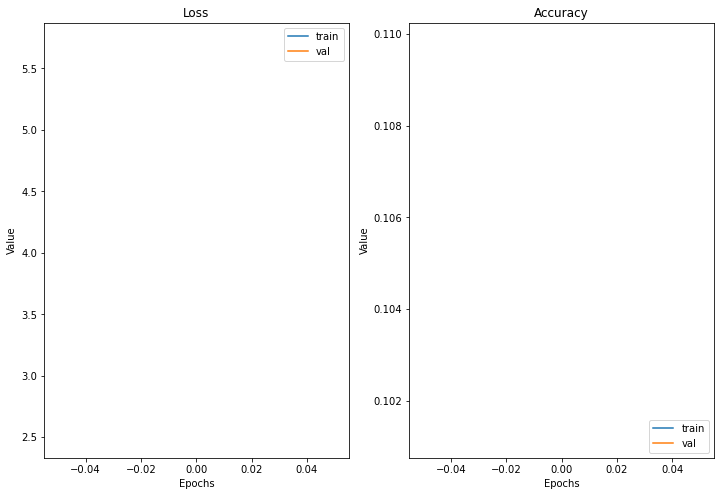

*******************number_2_kfold_model*******************
41/42 [============================>.] - ETA: 0s - loss: 5.9430 - accuracy: 0.0922
Epoch 00001: val_loss improved from inf to 2.49685, saving model to model1_best_0.h5
42/42 [==============================] - 2s 56ms/step - loss: 5.8628 - accuracy: 0.0938 - val_loss: 2.4968 - val_accuracy: 0.1083 - lr: 0.0010


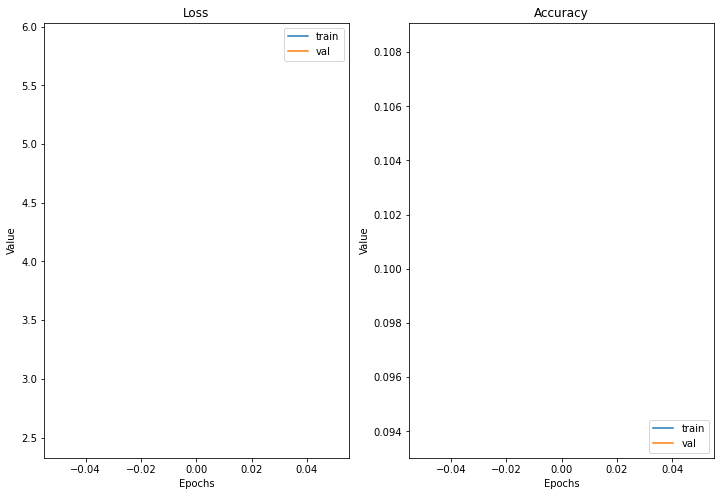

*******************number_3_kfold_model*******************
42/42 [==============================] - ETA: 0s - loss: 5.6866 - accuracy: 0.1138
Epoch 00001: val_loss improved from inf to 2.39103, saving model to model1_best_0.h5
42/42 [==============================] - 16s 391ms/step - loss: 5.6866 - accuracy: 0.1138 - val_loss: 2.3910 - val_accuracy: 0.1730 - lr: 0.0010


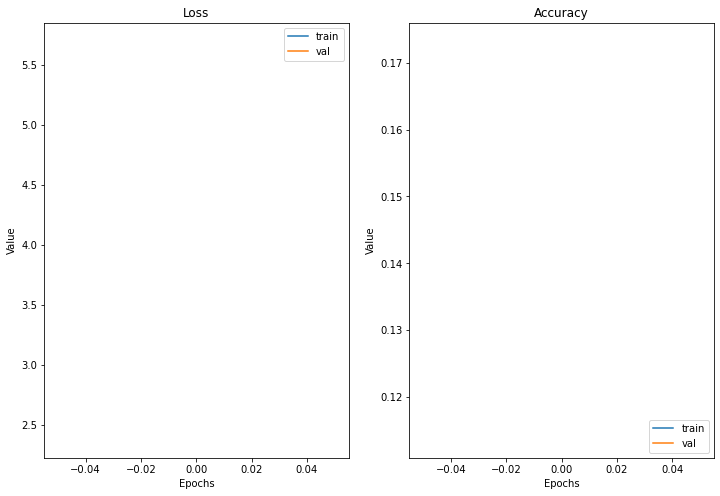

In [25]:
RX_train, RX_test = get_stacking(rexnet_model, X_trains, y_trains)

*******************number_1_kfold_model*******************
41/42 [============================>.] - ETA: 0s - loss: 6.2592 - accuracy: 0.1128
Epoch 00001: val_loss improved from inf to 6.03508, saving model to model1_best_0.h5
42/42 [==============================] - 26s 622ms/step - loss: 6.2172 - accuracy: 0.1153 - val_loss: 6.0351 - val_accuracy: 0.1201 - lr: 0.0010


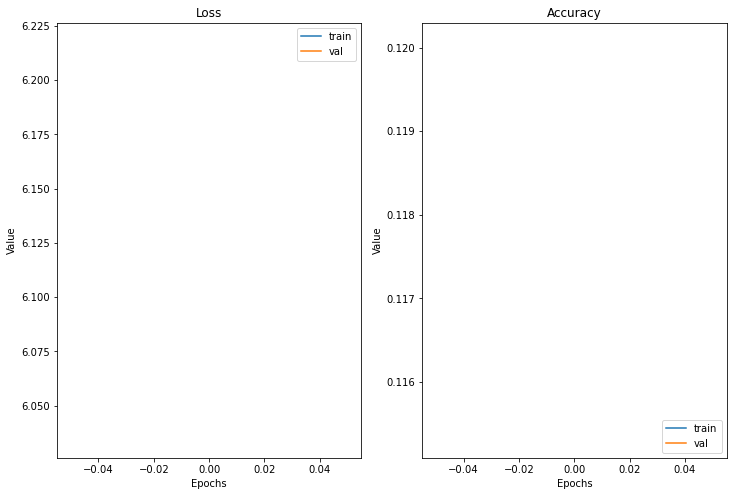

*******************number_2_kfold_model*******************
41/42 [============================>.] - ETA: 0s - loss: 6.2907 - accuracy: 0.1220
Epoch 00001: val_loss improved from inf to 7.29308, saving model to model1_best_0.h5
42/42 [==============================] - 3s 62ms/step - loss: 6.2298 - accuracy: 0.1235 - val_loss: 7.2931 - val_accuracy: 0.1083 - lr: 0.0010


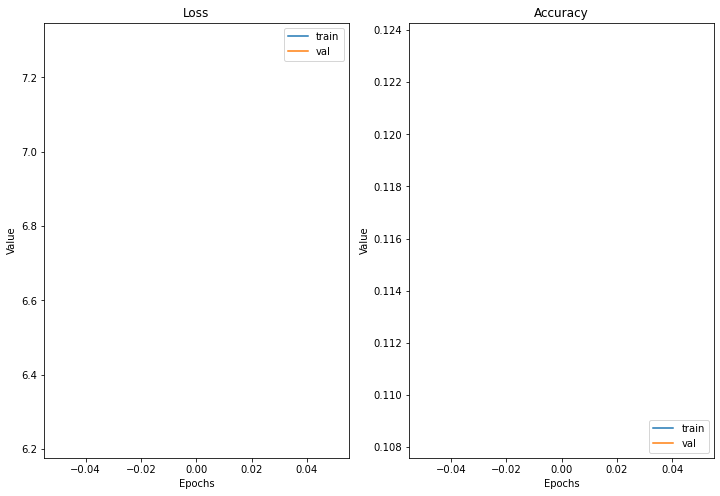

*******************number_3_kfold_model*******************
41/42 [============================>.] - ETA: 0s - loss: 6.2340 - accuracy: 0.1128
Epoch 00001: val_loss improved from inf to 7.56055, saving model to model1_best_0.h5
42/42 [==============================] - 15s 353ms/step - loss: 6.1854 - accuracy: 0.1124 - val_loss: 7.5606 - val_accuracy: 0.1290 - lr: 0.0010


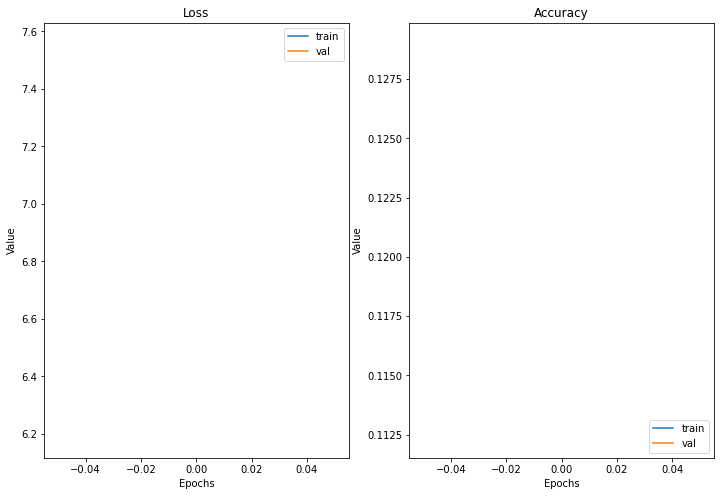

In [96]:
IN_train, IN_test = get_stacking(inception, X_trains, y_trains)

*******************number_1_kfold_model*******************
41/42 [============================>.] - ETA: 0s - loss: 7.0346 - accuracy: 0.0998
Epoch 00001: val_loss improved from inf to 40.90468, saving model to model1_best_0.h5
42/42 [==============================] - 36s 849ms/step - loss: 6.9415 - accuracy: 0.0997 - val_loss: 40.9047 - val_accuracy: 0.0864 - lr: 0.0010


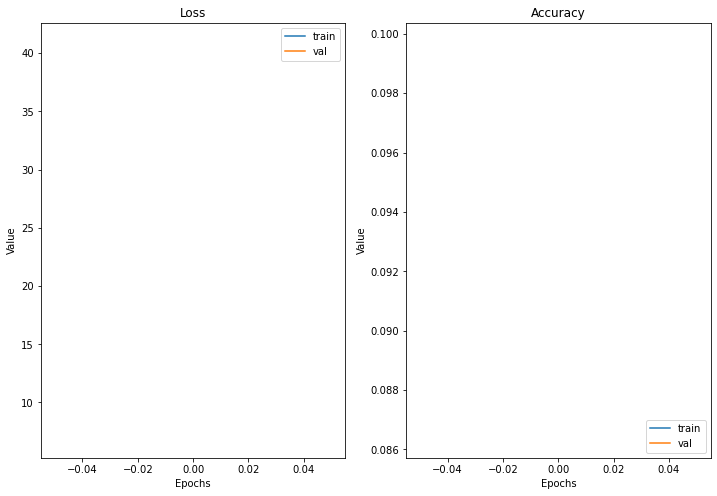

*******************number_2_kfold_model*******************
41/42 [============================>.] - ETA: 0s - loss: 5.7197 - accuracy: 0.1098
Epoch 00001: val_loss improved from inf to 7.41973, saving model to model1_best_0.h5
42/42 [==============================] - 3s 66ms/step - loss: 5.6595 - accuracy: 0.1086 - val_loss: 7.4197 - val_accuracy: 0.0922 - lr: 0.0010


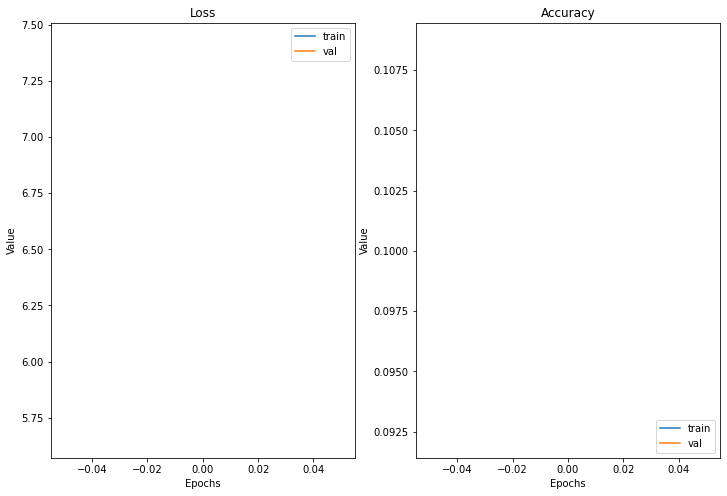

*******************number_3_kfold_model*******************
42/42 [==============================] - ETA: 0s - loss: 6.3321 - accuracy: 0.0990
Epoch 00001: val_loss improved from inf to 9.71544, saving model to model1_best_0.h5
42/42 [==============================] - 18s 417ms/step - loss: 6.3321 - accuracy: 0.0990 - val_loss: 9.7154 - val_accuracy: 0.0953 - lr: 0.0010


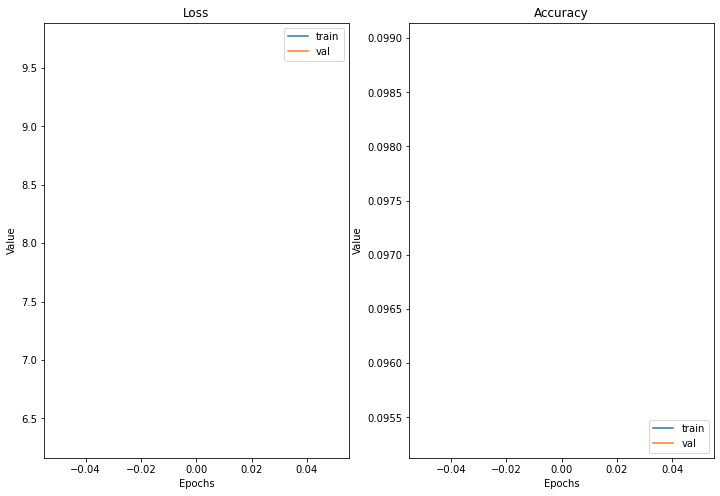

In [97]:
UC_train, UC_test = get_stacking(unet_classification, X_trains, y_trains)

In [42]:
# RX_train = RX_train.reshape((RX_train.shape[0]))
# RX_test = RX_test.reshape((RX_test.shape[0]))
# # UC_train = UC_train.reshape((UC_train.shape[0], 1))
# # UC_test = UC_test.reshape((UC_test.shape[0], 1)) 

In [98]:
RX_test

array([[2],
       [0],
       [8],
       ...,
       [0],
       [0],
       [0]])

In [99]:
new_X_train = np.concatenate((RX_train, IN_train, UC_train), axis = 1)
new_X_test = np.concatenate((RX_test, IN_test,  UC_test), axis = 1)
print('origin :', X_trains.shape, TEST.shape)
print('new : ', new_X_train.shape, new_X_test.shape)

origin : (2048, 28, 28, 3) (20480, 28, 28, 3)
new :  (2048, 3) (20480, 3)


In [102]:
y_trains.shape

(2048, 10)

In [103]:
new_y_train = np.argmax(y_trains, axis=1).reshape((y_trains.shape[0], 1))

In [104]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(n_estimators=200)
lgbm.fit(new_X_train, new_y_train)
final_pred = lgbm.predict(new_X_test)

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [105]:
final_pred

array([1, 0, 8, ..., 2, 2, 0])

In [106]:
submission['digit'] = final_pred

In [107]:
submission

,id,digit
0,2049,1
1,2050,0
2,2051,8
3,2052,2
4,2053,2
...,...,...
20475,22524,2
20476,22525,2
20477,22526,2
20478,22527,2


In [ ]:
submission.to_csv('./submission/rexnet_ensemble_channel3_submission.csv', index=False)